In [43]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [46]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [47]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [48]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [49]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [50]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Create inspector & connect to engine
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [51]:
##     Dataset types

In [52]:

measurement_columns = inspector.get_columns('Measurement')
for columns in measurement_columns: 
    print(columns["name"], columns["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [53]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date Measurement data was: {last_date}")

The most recent date Measurement data was: ('2017-08-23',)


In [54]:
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"12 months from last existing date: {last_12_months}")

12 months from last existing date: 2016-08-23


In [55]:
last_year_precipitation = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= last_12_months).order_by(Measurement.date).all()
print(f"last year preciptation: {last_year_precipitation}")


last year preciptation: [('2016-08-23', 0.0), ('2016-08-23', 0.15), ('2016-08-23', 0.05), ('2016-08-23', None), ('2016-08-23', 0.02), ('2016-08-23', 1.79), ('2016-08-23', 0.7), ('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08), ('2016-08-25', 0.08), ('2016-08-25', 0.0), ('2016-08-25', 0.0), ('2016-08-25', 0.21), ('2016-08-25', 0.06), ('2016-08-25', 0.11), ('2016-08-26', 0.0), ('2016-08-26', 0.03), ('2016-08-26', 0.02), ('2016-08-26', 0.04), ('2016-08-26', 0.0), ('2016-08-26', 0.01), ('2016-08-27', 0.0), ('2016-08-27', 0.18), ('2016-08-27', 0.02), ('2016-08-27', 0.0), ('2016-08-27', 0.12), ('2016-08-27', None), ('2016-08-28', 0.01), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.6), ('2016-08-28', 2.07), ('2016-08-29', 0.0), ('2016-08-29', 0.17), ('2016-08-29', 0.04), ('2016-08-29', None), ('2016-08-29', 0.0), ('2016-08-29', 0.3

In [56]:
prcp_1617_df = pd.DataFrame(last_year_precipitation, columns=['Date', 'Precipitation'])

prcp_1617_df.sort_values(by=['Date'])
prcp_1617_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


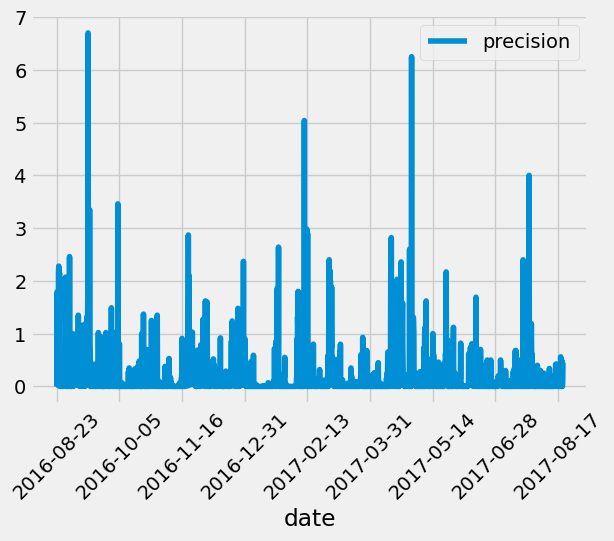

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns =["date", "precision"]).sort_values("date",ascending=True).dropna()
df.set_index(df["date"], inplace = True)

# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot = 45)
plt.show()

In [58]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_1617_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9,)]

In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_results = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [61]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

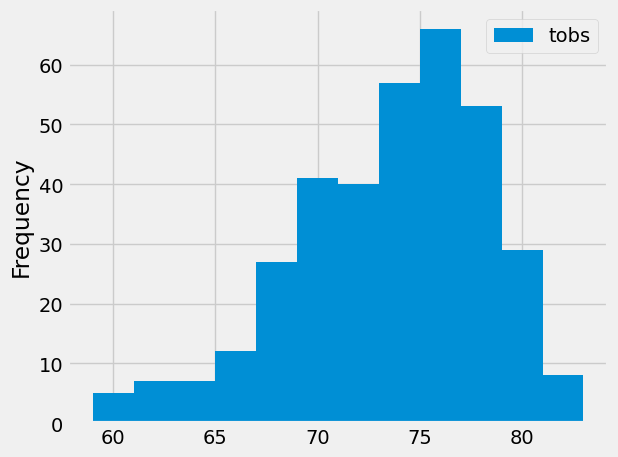

In [62]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_2 = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= prev_year).all()
df_2 = pd.DataFrame(result_2, columns = ["tobs"])
df_2.plot.hist(bins = 12)
plt.tight_layout()

In [63]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [64]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tobs_temps = calc_temps('2016-08-23','2017-08-23')
tobs_temps

[(58.0, 74.59058295964125, 87.0)]

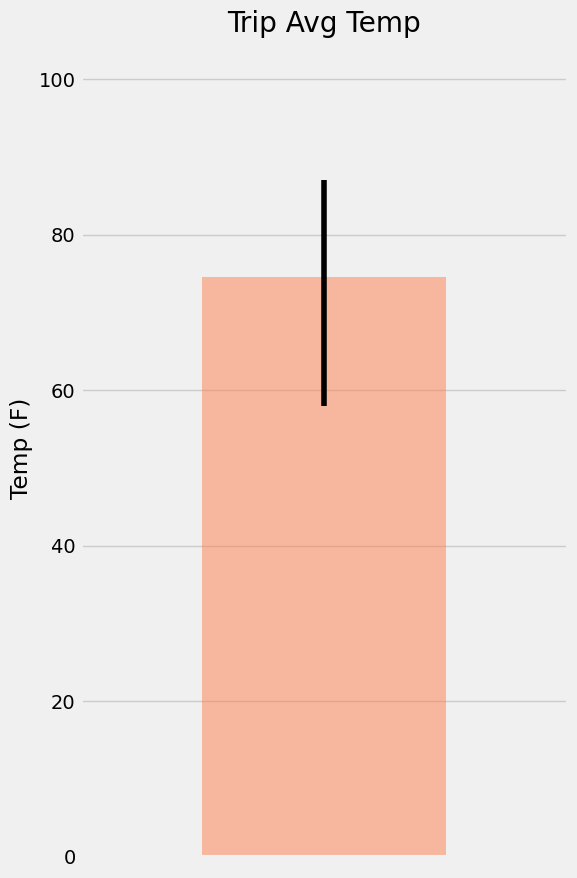

In [65]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTripTemp = tobs_temps[0][0]
avgTripTemp = tobs_temps[0][1]
maxTripTemp = tobs_temps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

tobs_temps_df = pd.DataFrame(tobs_temps, columns = ["tmin","tavg","tmax"])
tobs_temps_df.plot.bar(y ='tavg', yerr = np.array([[minError], [maxError]]),\
                       title='Trip Avg Temp', color ='coral', alpha = 0.5, figsize = (6,9))\
                       .get_xaxis().set_visible(False)
plt.ylim(0, 105)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.gca().legend_.remove()

In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
ws_rainfall = \
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2016-08-23').\
filter(Measurement.date <= '2017-08-23').\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(ws_rainfall)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

# Close Session

In [68]:
# Close Session
session.close()